we will work in this project with the famours MNIST data. THis is a handwritten database of digits and is so widely studied that many refer to it as the 'hello world' of machine learning. 

Lets get the project set up: 

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)


In [2]:
# check the data in mnist
X, y = mnist['data'], mnist['target']
print('X shape =', X.shape)
print('y shape =', y.shape)

X shape = (70000, 784)
y shape = (70000,)


We can see above that there are 70,000 images and each of the images has 784 pixels. The features in mnist represent the intensity of the pixel, where they vary fro 0 which is white to 255 which is black

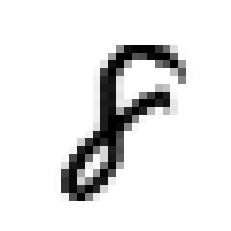

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[575]
some_digit_img = some_digit.reshape(28,28)
plt.imshow(some_digit_img, cmap = 'binary')
plt.axis('off')
plt.show()

In [4]:
# verify that this is an 8
y[575]

'8'

In [5]:
# conver to a nnumber as the algorithms do not take strings
import numpy as np
y=y.astype(np.uint8)

In [6]:
# lets create a test and train set, note that mnist is already random order 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

let's start with a more simple approach (a binary classifyer that simply predicts a single digit). we train the stochastic gradient descent classifiyer below. SGD is a highly efficient method as it learns from single instances independantly. It relies on randomness and therefore we must set the seed number. 

Notes on sgd: 
SGD Classifier implements regularised linear models with Stochastic Gradient Descent.Note that this algorithm is just a linear classifier optimised by the SGD.

In [7]:
y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)

In [8]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(random_state = 18)
sgd_clf.fit(X_train, y_train_1)# 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=18, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

now lets evaluate the performance with cross validation. We need a bit more control here and therefore we write a function tat extends beyond the cv score offered by sklearn. 

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_1):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_1[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_1[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))


C:\Users\ruair\cond\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.98765
0.99045
0.98985


In [10]:
# run the models 
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_1, cv = 3, scoring = 'accuracy')

array([0.98765, 0.99045, 0.98985])

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_1, cv = 3) # returns predictions made

In [ ]:
# check from aconfusion matrix rather than simply correct measures first row is the negative class and the second is pos
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train_1, y_train_pred)

we can evaluate the classifyers with precision and recall. Important to note that these metrics are often traded off against each other. That is; usually as the precision increases we will see a decrease in recall and this is called the precision recall tradeoff. Note that SGD can be optimised relative to your personal goals 

Precision = tp / tp + fp 


Recall = tp / tp + fn


f1 = 2 * precision x recall / precision + recall 


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_1, y_train_pred)

In [ ]:
recall_score(y_train_1, y_train_pred)

In [ ]:
f1_score(y_train_1, y_train_pred)

In [ ]:
# how can we decide on the threshold ofor the classifyer? 
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_1, cv = 3, method = 'decision_function')
precisions,recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)

def plt_ROC(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    
plt_ROC(fpr, tpr)
plt.show()

In [ ]:
def plt_dt(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.legend()

plt_dt(precisions, recalls, thresholds)

plt.show()

In [ ]:
# if we have a defined precision we need we can extract the threshold value i.e. 95% 
thresholds[np.argmax(precisions >=0.95)]

ROC curve 

is a tool we can used in binary classifications. It plots the true positive vs false positive (1-TPR). We can evalueate the differences between classifyers with the roc AUC score, which lies between 1 (perfect) and 0.5 (random guesses)  

In [ ]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_train_1, y_scores)

In [ ]:
# lets compare to a random forest nb that predict proba returns a probabilistic estimate of the accuracy per prediction
from sklearn.ensemble import RandomForestClassifier 
forest_clf = RandomForestClassifier(random_state = 18)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_1, cv = 3, method = 'predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_1, y_scores_forest)

In [ ]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plt_ROC(fpr_forest, tpr_forest, 'RF')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
print('SGD AUC',roc_auc_score(y_train_1, y_scores))
print('RF AUC',roc_auc_score(y_train_1, y_scores_forest))

# Multiclass 

In [ ]:
from sklearn.svm import SVC # try svm 

In [ ]:
svm_clf = SVC() # support vector machine classfiyer 
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC()) 
ovr_clf.fit(X_train, y_train)
digit_scores = svm_clf.decision_function([some_digit]) 
digit_scores # score per digit out

In [ ]:
from sklearn.preprocessing import StandardSCaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = 'accuracy') # in this example we can impore accuracy by scaling 

# Error work 

we can use the method below to understand where the common errors are. 

In [ ]:
# let's first create a c mat
y_train_predictions = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_m = confusion_matrix(y_train, y_train_predictions)
conf_m

In [ ]:
plt.matshow(conf_m)
plt.show()

In [ ]:
# if we now look at where the common errors are 
row_sums = conf_m.sum(axis=1, keepdims=True)
norm_fonf_m = conf_m/row_sums

# Multilabel 

In [ ]:
# we can use multiclass where the output is more than 1
from sklearn.neighbours import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd] # concat these outputs 
knn_clf = KNeighborsClassifier(
knn_clf.fit(X_train, y_multilabel) # now we get an output if large AND odd 
knn_clf.fit([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilevel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro') # compute f1 across all levels 

# Multioutput classification 

In [ ]:
# we are going to add noise to the mnist data 
noise = np.random.randint(0,100, len(X_train), 784)
X_train_mod = X_train + noise
noise = np.random.randint(0,100, len(X_test), 784)
X_test_mod = X_test + noise

y_train_mod = X_train 
y_test_mod = X_test


In [ ]:
idx = 452
plt.subplot(121); plot_digit(X_test_mod[idx])
plt.subplot(122); plot_digit(y_test_mod[idx])
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)